### **Imported Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import boxcox1p
from scipy.stats.mstats import winsorize
from scipy.stats import yeojohnson

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(color_codes=True)

### **Data Loading**

In [2]:
# Loading data into dataframe
ctr_data = pd.read_csv('T_CONTRAT2.csv', parse_dates=['DAT_SIGN_CTR', 'DAT_DEB_CTR', 'DAT_RESIL_CTR', 'DAT_PROCH_VERS_CTR'])
his_data = pd.read_csv('T_HISTORIQUE2.csv', parse_dates=['DATE_ACTION'])
enc_data = pd.read_csv('T_ENCAISSEMENT2.csv', parse_dates=['DAT_RECEP_ENC', 'DAT_VAL_ENC'])
detb_data = pd.read_csv('T_T_DET_BORD2.csv', parse_dates=['DAT_DET_BORD', 'ECH_DET_BORD'])
fin_data = pd.read_csv('T_FIN2.csv', parse_dates=['DAT_FIN', 'DAT_INSTR_FIN'])
imp_data = pd.read_csv('T_IMP2.csv', parse_dates=['DATE_IMP', 'DATE_SAISI_IMP'])

In [3]:
# Display few rows of the contract table
ctr_data.head()

,REF_CTR,STATUT_CTR,REF_CTR_PAPIER_CTR,TYP_CTR,DAT_SIGN_CTR,DAT_DEB_CTR,DAT_RESIL_CTR,DAT_PROCH_VERS_CTR,CA_CTR,CA_EXP_CTR,...,LIM_FIN_CTR,DEVISE_CTR,NB_ACH_PREVU_CTR,NB_FACT_PREVU_CTR,NB_AVOIRS_PREVU_CTR,NB_REMISES_PREVU_CTR,DELAI_MOYEN_REG_CTR,DELAI_MAX_REG_CTR,FACT_REG_CTR,DERN_MONT_DISP_2
0,8,V,001/2014,Avec recours,2014-04-01,2014-02-11,2014-04-01,2014-02-11,0.000,0.0,...,0.000,TND,0,0,0,0,0,0.0,True,0.0
1,9,A,001/2014,Avec recours,2014-01-27,2014-01-27,2014-02-11,2014-02-11,4000000.000,0.0,...,0.000,TND,90,90,0,90,120,120.0,True,0.0
2,10,V,002/2014,Avec recours,2014-01-27,2014-01-27,2014-02-11,2014-02-11,5000000.000,0.0,...,2252585.300,TND,10,90,0,90,90,120.0,True,0.0
3,11,V,004/2014,Avec recours,2014-01-27,2014-01-27,2014-02-12,2014-02-12,1500000.000,0.0,...,94055.000,TND,50,80,0,0,120,120.0,True,0.0
4,18,V,003/2013,Avec recours,2014-02-12,2014-02-12,2014-02-12,2014-02-12,256648.412,0.0,...,256648.412,TND,10,30,0,0,90,90.0,True,0.0


In [4]:
# Display few rows of the history table
his_data.head()

,DATE_ACTION,ACTION,T_TABLE,ID_ENREGISTREMENT,LOGIN_USER,IP_PC,NOM_PC,REF_CTR_HIST,REF_IND_HIST,ABREV_ROLE_HIST,ID_HISTORIQUE
0,2019-01-11,Ajout,TR_TMM,198,cyrine,192.168.49.151,SRVXFACTORWEB,125.0,232.0,Ajout 125.0,3
1,2019-11-22,Modification,T_DET_BORD,31004,cyrine,192.168.49.151,SRVXFACTORWEB,95.0,975.0,Modification 95.0,4
2,2019-11-22,Modification,TJ_DOCUMENT_DET_BORD,10955,cyrine,192.168.49.151,SRVXFACTORWEB,95.0,232.0,Modification 95.0,5
3,2019-11-22,Modification,T_DET_BORD,31005,cyrine,192.168.49.151,SRVXFACTORWEB,95.0,975.0,Modification 95.0,6
4,2019-11-22,Modification,TJ_DOCUMENT_DET_BORD,10956,cyrine,192.168.49.151,SRVXFACTORWEB,95.0,232.0,Modification 95.0,7


In [5]:
# Display few rows of the encaissement table
enc_data.head()

,ID_ENC,REF_CTR_ENC,REF_ADH_ENC,REF_ACH_ENC,MONT_ENC,DEVISE_ENC,DAT_RECEP_ENC,DAT_VAL_ENC,TYP_ENC,VALIDE_ENC,REF_ENC
0,10,10,8.0,28.0,4840.0,TND,2014-03-01,2014-07-02,T,True,29638
1,11,10,8.0,28.0,40000.0,TND,2014-03-01,2014-07-02,C,True,40405
2,12,10,8.0,28.0,27000.0,TND,2014-03-01,2014-07-02,T,True,29735
3,13,10,8.0,28.0,40000.0,TND,2014-03-01,2014-07-02,T,True,40502
4,14,10,8.0,28.0,28435.4,TND,2014-03-01,2014-07-02,T,True,2714


In [6]:
# Display few rows of the details bordereaux table
detb_data.head()

,ID_DET_BORD,REF_CTR_DET_BORD,NUM_BORD,TYP_DET_BORD,DAT_DET_BORD,MONT_TTC_DET_BORD,DEVISE_DET_BORD,ECH_DET_BORD,MONT_OUV_DET_BORD,MODE_REG_DET_BORD,...,ANNUL_DET_BORD,VALIDE_DET_BORD,REF_IND_DET_BORD,MONT_FDG_DET_BORD,MONT_FDG_LIBERE_DET_BORD,MONT_COMM_FACT_DET_BORD,TX_TVA_COMM_FACT_DET_BORD,MONT_TVA_COMM_FACT_DET_BORD,MONT_TTC_COMM_FACT_DET_BORD,RETENU_DET_BORD
0,1,26,29,fact,2014-03-28,258518.400,TND,120.0,0.0,T,...,False,True,31,0.0,0.0,3877.776,0.18,698.0,4575.776,0.0
1,10,9,26,fact,2014-03-29,12369.899,TND,0.0,0.0,C,...,False,True,30,0.0,0.0,185.548,0.00,0.0,185.548,0.0
2,101,9,10,fact,2014-02-06,48570.000,TND,0.0,0.0,C,...,False,True,32,0.0,0.0,728.550,0.00,0.0,728.550,0.0
3,1010,21,10,fact,2014-02-17,5148.976,TND,0.0,0.0,C,...,False,True,124,0.0,0.0,51.490,0.00,0.0,51.490,0.0
4,1011,21,10,fact,2014-02-17,37005.790,TND,0.0,0.0,C,...,False,True,125,0.0,0.0,370.058,0.00,0.0,370.058,0.0


In [7]:
# Display few rows of the finance table
fin_data.head()

,REF_CTR_FIN,MONT_FIN,DAT_FIN,INSTR_FIN,REF_INSTR_FIN,DAT_INSTR_FIN,ETAT_FIN,REF_INSTR_FIN_filled
0,9,4091792.969,2014-01-31,Cheque,0,2018-06-07,1,2019267
1,11,94055.000,2018-09-13,Cheque,0,2018-06-07,1,2019267
2,18,256648.412,2014-02-27,Cheque,0,2018-06-07,1,2019267
3,19,135566.736,2018-09-13,Cheque,0,2018-06-07,1,2019267
4,20,45064.723,2018-09-13,Cheque,0,2018-06-07,1,2019267


In [8]:
# Display few rows of the impaye table
imp_data.head()

,ID_IMP,ID_ENC_IMP,DATE_IMP,DATE_SAISI_IMP,MONT_IMP,Duration
0,1,320,2014-05-12,2014-12-19,14775.00,-14
1,3,947,2014-03-12,2014-12-27,5000.00,-24
2,5,837,2014-12-25,2014-12-31,5000.00,-6
3,6,836,2014-12-26,2015-06-01,28449.75,-11
4,7,976,2015-10-01,2015-06-02,10757.00,-27


The purpose of this notebook is to make deeper analysis for the prediction need. So, it's inconvenient to deal with each table one-by-one. As a recommendation, it's better to merge between the tables to end up with a single dataset and to facilitate the preprocessing cycle we are going to encounter.

In [9]:
# Print out the primary keys and the the secondary keys that relate all the tables to the ctr table
print(sorted(set(ctr_data['REF_CTR'])))
print(sorted(set(his_data['REF_CTR_HIST'])))
print(sorted(set(enc_data['REF_CTR_ENC'])))
print(sorted(set(detb_data['REF_CTR_DET_BORD'])))
print(sorted(set(fin_data['REF_CTR_FIN'])))
print(sorted(set(imp_data['ID_ENC_IMP'])))
print(sorted(set(enc_data['ID_ENC'])))
print(ctr_data['REF_CTR'].dtype, his_data['REF_CTR_HIST'].dtype, enc_data['REF_CTR_ENC'].dtype, detb_data['REF_CTR_DET_BORD'].dtype, fin_data['REF_CTR_FIN'].dtype, imp_data['ID_ENC_IMP'].dtype, enc_data['ID_ENC'].dtype)

[8, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 1128, 1129, 1130, 1131, 2127, 2128, 2129, 2130, 2131, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135]
[0.0, 1.0, 9.0, 10.0, 20.0, 22.0, 27.0, 35.0, 39.0, 40.0, 41.0, 42.0, 43.0, 45.0, 46.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 57.0, 60.0, 61.0, 62.0, 63.0, 64.0, 66.0, 67.0, 68.0, 71.0, 73.0, 74.0, 75.0, 83.0, 85.0, 86.0, 88.0, 90.0, 94.0, 95.0, 96.0, 98.0, 100.0, 101.0, 103.0, 105.0, 108.0, 109.0, 112.0, 115.0, 119.0, 120.0, 121.0, 122.0, 123.0, 125.0, 126.0, 127.0, 128.0, 1128.0, 1129.0, 1130.0, 1131.0, 2127.0, 2128.0, 2129.0, 2130.0, 2131.0,

By checking out the similarities between those keys, it's possible to merge between the tables. But one step ahead needs to be applied, the REF_CTR_HIST column in the history table requires a casting type to integer like all the fellows.

In [10]:
# Cast REF_CTR_HIST to int
his_data['REF_CTR_HIST'] = his_data['REF_CTR_HIST'].astype('Int64')

Let's merge now.

In [11]:
# # Combine tables
# try:
#         dataset = ctr_data.merge(enc_data, left_on='REF_CTR', right_on='REF_CTR_ENC', how='inner').drop_duplicates() \
#                 .merge(detb_data, left_on='REF_CTR', right_on='REF_CTR_DET_BORD', how='inner').drop_duplicates() \
#                 .merge(fin_data, left_on='REF_CTR', right_on='REF_CTR_FIN', how='inner').drop_duplicates() \
#                 .merge(imp_data, left_on='ID_ENC', right_on='ID_ENC_IMP', how='inner').drop_duplicates().drop_duplicates()
# except MemoryError:
#         print('Not able to merge tables, due to memory error ')
# except:
#         print('Something else hang out the merge.')
# else:
#         # Display few rows
#         dataset.head()

It seems we can't make combination because of the leak of memory usage. As a solution. we will be dealing with outliers first (either by removing them or winsorizing them).
The tables that have least outliers are passing through the deletion action, whereas the rest are facing the winsorizing step.

### **Data Preprocessing**

#### **Worktools**
This section holds all methods that help in the preprocessing step.

In [12]:

def remove_columns_starting_with_prefix(df, prefix_list=['REF', 'ID']):
    """
    Remove columns from a DataFrame that start with specified prefixes.

    Parameters:
        df (DataFrame): The input DataFrame.
        prefix_list (list): A list of prefixes to search for and remove.

    Returns:
        DataFrame: The DataFrame with specified columns removed.
    """
    # Create a list of columns to remove
    columns_to_remove = [col for col in df.columns if any(col.startswith(prefix) for prefix in prefix_list)]
    
    # Remove the selected columns
    df = df.drop(columns=columns_to_remove)
    
    return df

In [13]:
def visualize_outliers(df):
    """
    Visualize outliers of each numerical column with boxplots in a single subplot.

    Parameters:
        df (DataFrame): The input DataFrame containing numerical columns to visualize.

    Returns:
        None
    """
    # Copy dataframe
    cdf = df.copy()

    # Remove columns that start with specific prefix
    cdf = remove_columns_starting_with_prefix(cdf)
    
    # Get a list of numerical columns from the DataFrame
    numerical_columns = cdf.select_dtypes(include=['int64', 'float64']).columns
    
    # Calculate the number of rows needed for the subplot grid
    num_rows = len(numerical_columns)

    if num_rows < 2:
        plt.boxplot(cdf[numerical_columns[0]])
    else:
        # Create a subplot grid
        fig, ax = plt.subplots(num_rows, 1, figsize=(8, 4*num_rows))
        
        # Create boxplots for each numerical column
        for i, col in enumerate(numerical_columns):
            ax[i].boxplot(cdf[col], vert=False)
            ax[i].set_title(col)
        
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [14]:
def identify_columns_with_outliers(d, threshold=1.5):
    """
    Identify columns with outliers in a DataFrame and calculate the total number of outliers and rows with outliers.

    Parameters:
        df (DataFrame): The input DataFrame.
        threshold (float): The IQR multiplier to determine outliers. Default is 1.5.

    Returns:
        dict: A dictionary containing information about columns with outliers and the number of rows with outliers.
    """
    # Copy dataframe
    df = d.copy()

    # Remove columns that start with specific prefix
    df = remove_columns_starting_with_prefix(d)
    
    # Create an empty dictionary and a list to store the results
    outliers_info = {}
    indexes = []
    
    # Variable to count rows with outliers
    rows_with_outliers = 0
    
    # Iterate through columns
    for col in df.columns:
        if df[col].dtype in [np.int64, np.float64]:  # Check if the column is numeric
            # Calculate the IQR for the column
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Define the upper and lower bounds for outliers
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            # Identify outliers in the column
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            indexes.extend(list(outliers.index))

            # Count the number of outliers
            num_outliers = len(outliers)
            
            # Add the column and number of outliers to the dictionary
            if num_outliers > 0:
                outliers_info[col] = num_outliers
                
                # Count the number of rows with outliers
                rows_with_outliers += len(outliers)
    
    # Create a dictionary to return the results
    results = {
        "columns_with_outliers": outliers_info,
        "total_rows_with_outliers": f'{len(set(indexes))} / {df.shape[0]}',
        'total_outliers': len(set(indexes))
    }
    
    return results

In [15]:
def transform_outliers_with_boxcox(df, threshold=1.5):
    """
    Apply the Box-Cox transformation to outliers in selected columns of a DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame.
        threshold (float): The IQR multiplier to determine outliers. Default is 1.5.

    Returns:
        DataFrame: A new DataFrame with selected columns' outliers transformed using the Box-Cox transformation.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    transformed_df = df.copy()
    
    # Get a list of columns that do not start with 'REF' or 'ID'
    selected_columns = [col for col in transformed_df.columns if not col.startswith(('REF', 'ID'))]
    
    # Iterate through selected columns
    for col in selected_columns:
        if transformed_df[col].dtype in [np.int64, np.float64]:  # Check if the column is numeric
            # Check if the column has constant data (all values are the same)
            unique_values = transformed_df[col].unique()
            if len(unique_values) > 1:
                # Calculate the IQR for the column
                Q1 = transformed_df[col].quantile(0.25)
                Q3 = transformed_df[col].quantile(0.75)
                IQR = Q3 - Q1

                # Define the upper and lower bounds for outliers
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR

                # Identify outliers in the column
                outliers = transformed_df[(transformed_df[col] < lower_bound) | (transformed_df[col] > upper_bound)]

                # Check if there are any outliers
                if not outliers.empty:
                    # Apply the Box-Cox transformation to outliers using boxcox1p
                    transformed_outliers = boxcox1p(outliers[col], 0.15)  # 0.15 is the lambda parameter
                    transformed_df.loc[outliers.index, col] = transformed_outliers
    
    return transformed_df

In [16]:
def transform_with_yeojohnson(df):
    """
    Apply the Yeo-Johnson transformation to numeric columns in a DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame.

    Returns:
        DataFrame: A new DataFrame with Yeo-Johnson transformed numeric columns.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    transformed_df = df.copy()
    
    # Get a list of numeric columns
    numeric_columns = transformed_df.select_dtypes(include=[np.number]).columns.tolist()

    # Get a list of columns that do not start with 'REF' or 'ID'
    numeric_columns = [col for col in numeric_columns if not col.startswith(('REF', 'ID'))]

    # Iterate through numeric columns
    for col in numeric_columns:
        # Apply the Yeo-Johnson transformation to the column
        transformed_values, _ = yeojohnson(transformed_df[col])
        transformed_df[col] = transformed_values

    return transformed_df

In [17]:
def handle_outliers_with_winsorize(df, lower_percentile=0.05, upper_percentile=0.95):
    """
    Handle outliers in a DataFrame using winsorization.

    Parameters:
        df (DataFrame): The input DataFrame.
        lower_percentile (float): Lower percentile to clip values. Default is 0.05 (5th percentile).
        upper_percentile (float): Upper percentile to clip values. Default is 0.95 (95th percentile).

    Returns:
        DataFrame: A new DataFrame with outliers winsorized.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    winsorized_df = df.copy()

    # Get a list of columns that do not start with 'REF' or 'ID'
    selected_columns = [col for col in winsorized_df.columns if not col.startswith(('REF', 'ID'))]

    # Iterate through selected columns
    for col in selected_columns:
        if winsorized_df[col].dtype in [np.int64, np.float64]:  # Check if the column is numeric
            # Apply winsorization to the column
            winsorized_values = winsorize(winsorized_df[col], limits=(lower_percentile, upper_percentile))
            winsorized_df[col] = winsorized_values

    return winsorized_df

In [18]:
def replace_outliers_with_median(df, threshold=1.5):
    """
    Replace outliers with the median in numeric columns and display histograms for columns that had outliers.

    Parameters:
        df (DataFrame): The input DataFrame.
        threshold (float): The IQR multiplier to determine outliers. Default is 1.5.

    Returns:
        None (displays histograms).
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    processed_df = df.copy()

    # Get a list of numeric columns
    numeric_columns = processed_df.select_dtypes(include=[np.number]).columns.tolist()

    # Get a list of columns that do not start with 'REF' or 'ID'
    numeric_columns = [col for col in numeric_columns if not col.startswith(('REF', 'ID'))]

    # Create a dictionary to store column names with outliers
    columns_with_outliers = {}
    outliers_still_exist = True

    # Iterate through numeric columns
    while outliers_still_exist:
        for col in numeric_columns:
            # Calculate the IQR for the column
            Q1 = processed_df[col].quantile(0.25)
            Q3 = processed_df[col].quantile(0.75)
            IQR = Q3 - Q1

            # Define the upper and lower bounds for outliers
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            # Identify outliers in the column
            outliers = processed_df[(processed_df[col] < lower_bound) | (processed_df[col] > upper_bound)]

            # Check if there are any outliers
            if not outliers.empty:
                # Replace outliers with the median
                median_value = processed_df[col].median()
                processed_df.loc[outliers.index, col] = median_value

                # Store the column name in the dictionary
                columns_with_outliers[col] = outliers
                outliers_still_exist = True
            else:
                outliers_still_exist = False

    return processed_df

In [19]:
def remove_outliers_with_percent(df, threshold=1.5, remove_percent=0.6):
    """
    Remove a percentage of outliers from numeric columns and replace the remaining with the median.

    Parameters:
        df (DataFrame): The input DataFrame.
        threshold (float): The IQR multiplier to determine outliers. Default is 1.5.
        remove_percent (float): The percentage of outliers to remove. Default is 0.6.
        replace_percent (float): The percentage of outliers to replace with the median. Default is 0.4.

    Returns:
        DataFrame: A new DataFrame with outliers handled as specified.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    processed_df = df.copy()

    # Get a list of numeric columns
    numeric_columns = processed_df.select_dtypes(include=[np.number]).columns.tolist()

    # Get a list of columns that do not start with 'REF' or 'ID'
    numeric_columns = [col for col in numeric_columns if not col.startswith(('REF', 'ID'))]

    # Iterate through numeric columns
    for col in numeric_columns:
        # Calculate the IQR for the column
        Q1 = processed_df[col].quantile(0.25)
        Q3 = processed_df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define the upper and lower bounds for outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Identify outliers in the column
        outliers = processed_df[(processed_df[col] < lower_bound) | (processed_df[col] > upper_bound)]

        # Calculate the number of outliers to remove and replace
        num_outliers = len(outliers)
        num_to_remove = int(num_outliers * remove_percent)

        # Remove the specified percentage of outliers
        if num_to_remove > 0:
            to_remove = outliers.sample(n=num_to_remove, random_state=42)
            processed_df.drop(to_remove.index, inplace=True)

    return processed_df

In [20]:
def normalize_numeric_columns(df, method='min-max'):
    """
    Normalize numeric columns in a DataFrame using Min-Max scaling or Z-score normalization.

    Parameters:
        df (DataFrame): The input DataFrame.
        method (str): The normalization method to use ('min-max' or 'z-score'). Default is 'min-max'.

    Returns:
        DataFrame: A new DataFrame with normalized numeric columns.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    normalized_df = df.copy()

    # Get a list of numeric columns
    numeric_columns = normalized_df.select_dtypes(include=[np.number]).columns.tolist()

    # Get a list of columns that do not start with 'REF' or 'ID'
    numeric_columns = [col for col in numeric_columns if not col.startswith(('REF', 'ID'))]

    # Iterate through numeric columns
    for col in numeric_columns:
        if method == 'min-max':
            # Min-Max scaling
            min_value = normalized_df[col].min()
            max_value = normalized_df[col].max()
            normalized_df[col] = (normalized_df[col] - min_value) / (max_value - min_value)
        elif method == 'z-score':
            # Z-score normalization
            mean_value = normalized_df[col].mean()
            std_value = normalized_df[col].std()
            normalized_df[col] = (normalized_df[col] - mean_value) / std_value

    return normalized_df

In [21]:
def remove_outliers(df, threshold=1.5):
    """
    Remove outliers from a DataFrame using the IQR method.

    Parameters:
        df (DataFrame): The input DataFrame.
        threshold (float): The IQR multiplier to determine outliers. Default is 1.5.

    Returns:
        DataFrame: A new DataFrame with outliers removed.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    cleaned_df = df.copy()

    # Iterate through columns
    for col in cleaned_df.columns:
        if cleaned_df[col].dtype in [np.int64, np.float64]:  # Check if the column is numeric
            # Calculate the IQR for the column
            Q1 = cleaned_df[col].quantile(0.25)
            Q3 = cleaned_df[col].quantile(0.75)
            IQR = Q3 - Q1

            # Define the upper and lower bounds for outliers
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            # Remove outliers in the column
            cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]

    return cleaned_df

In [22]:
def preprocess_data(data):
    # Create a copy of the original DataFrame to avoid modifying the original data
    processed_data = data.copy()
    
    # Normalize numerical columns using StandardScaler
    numerical_columns = processed_data.select_dtypes(include=['number']).columns
    for col in numerical_columns:
        if col != 'Credibility':
            scaler = StandardScaler()
            processed_data[col] = scaler.fit_transform(processed_data[[col]])
    
    # Transform datetime columns into timestamps
    datetime_columns = processed_data.select_dtypes(include=['datetime64']).columns
    for col in datetime_columns:
        if col != 'Credibility':
            processed_data[col] = processed_data[col].apply(lambda x: x.timestamp())
    
    # Encode categorical columns using LabelEncoder
    categorical_columns = processed_data.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if col != 'Credibility':
            label_encoder = LabelEncoder()
            processed_data[col] = label_encoder.fit_transform(processed_data[col])
    
    # Ensure 'Credibility' remains as the target column
    processed_data['Credibility'] = data['Credibility']
    
    return processed_data

In [23]:
def get_correlated_columns(data, threshold=0.44):
    """
    Get columns with correlation greater than threshold or less than -threshold with 'Credibility'.

    Parameters:
        data (DataFrame): The input DataFrame.
        threshold (float): The correlation threshold. Default is 0.44.

    Returns:
        DataFrame: A DataFrame containing columns with correlation above or below the threshold.
    """
    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Get the correlation with 'Credibility' column
    correlation_with_credibility = correlation_matrix['Credibility']

    # Filter columns based on the threshold
    correlated_columns = correlation_with_credibility[
        (correlation_with_credibility > threshold) | (correlation_with_credibility < -threshold)
    ]

    # Create a DataFrame containing the correlated columns
    correlated_data = data[correlated_columns.index]

    return correlated_data

In [24]:
# Function to create custom confusion matrix
def custom_confusion_matrix(df, y_test, y_preds):
    my_palette = sns.color_palette("pastel", 4)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cbar=True, cmap=['#E97777', '#93C6E7', '#54BAB9'])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    
    fig.canvas.draw()
    # labels = list(df['Credibility'])

    # ax.set_xticklabels(labels)
    # ax.set_yticklabels(labels)

#### **Preprocessing Cycle**

##### **1. Check Outliers**


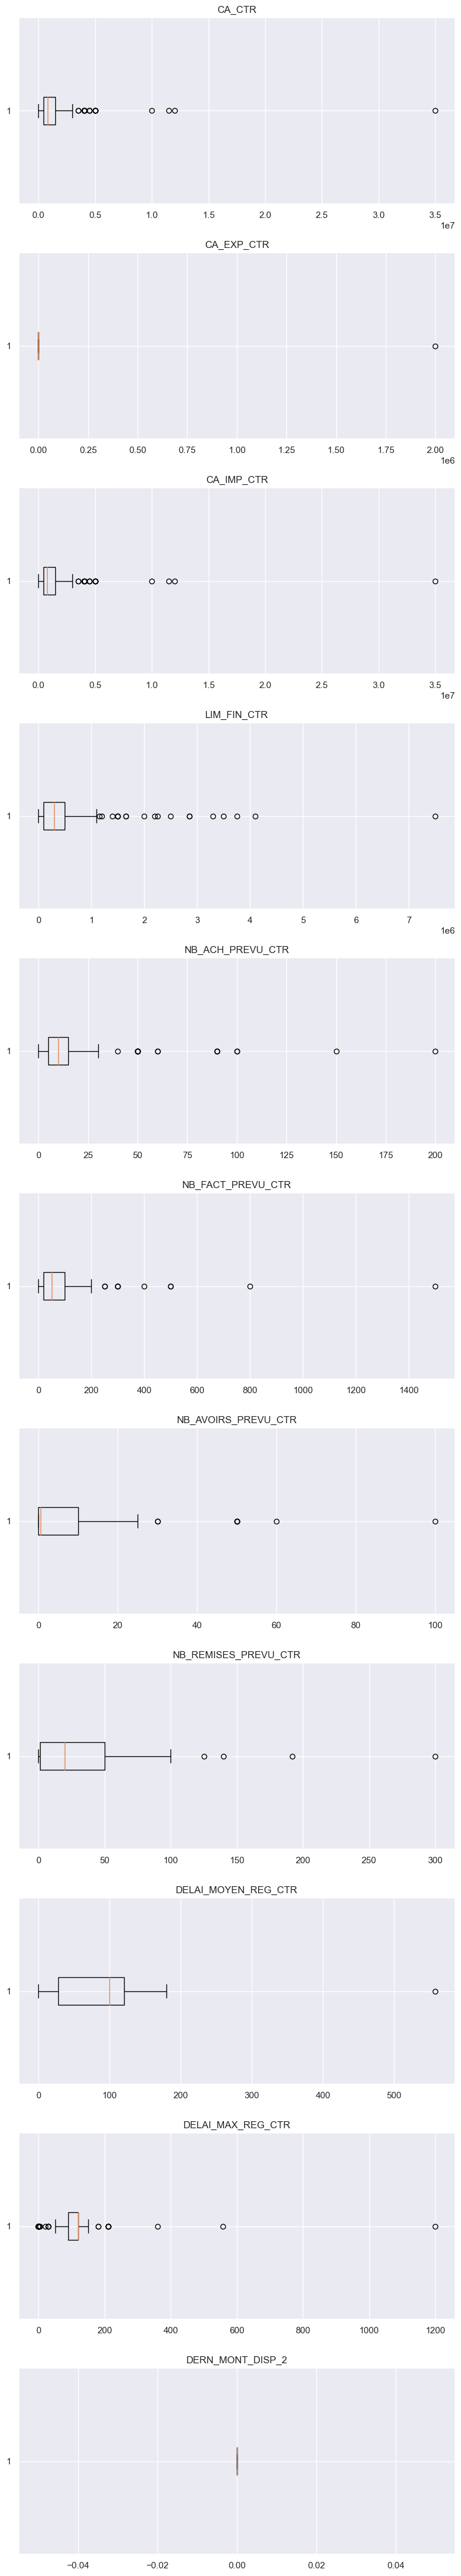

{'columns_with_outliers': {'CA_CTR': 18,
  'CA_EXP_CTR': 1,
  'CA_IMP_CTR': 18,
  'LIM_FIN_CTR': 19,
  'NB_ACH_PREVU_CTR': 16,
  'NB_FACT_PREVU_CTR': 10,
  'NB_AVOIRS_PREVU_CTR': 8,
  'NB_REMISES_PREVU_CTR': 4,
  'DELAI_MOYEN_REG_CTR': 1,
  'DELAI_MAX_REG_CTR': 25},
 'total_rows_with_outliers': '57 / 124',
 'total_outliers': 57}

In [25]:
# Visualize outliers in the contract table
visualize_outliers(ctr_data)

# Identify outliers 
identify_columns_with_outliers(ctr_data)

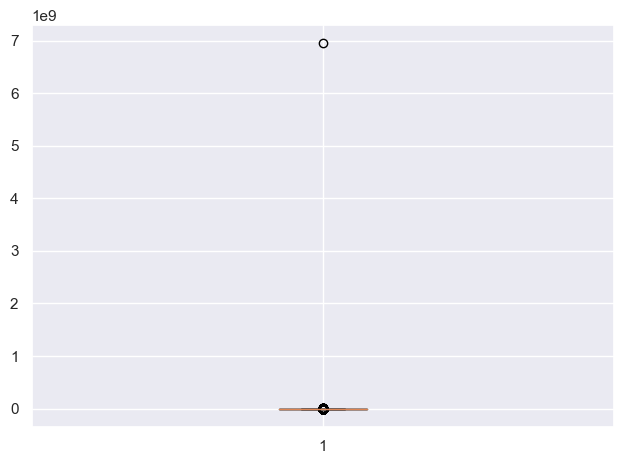

{'columns_with_outliers': {'MONT_ENC': 541},
 'total_rows_with_outliers': '541 / 13772',
 'total_outliers': 541}

In [26]:
# Visualize outliers in encaissement table
visualize_outliers(enc_data)

# Identify outliers
identify_columns_with_outliers(enc_data)

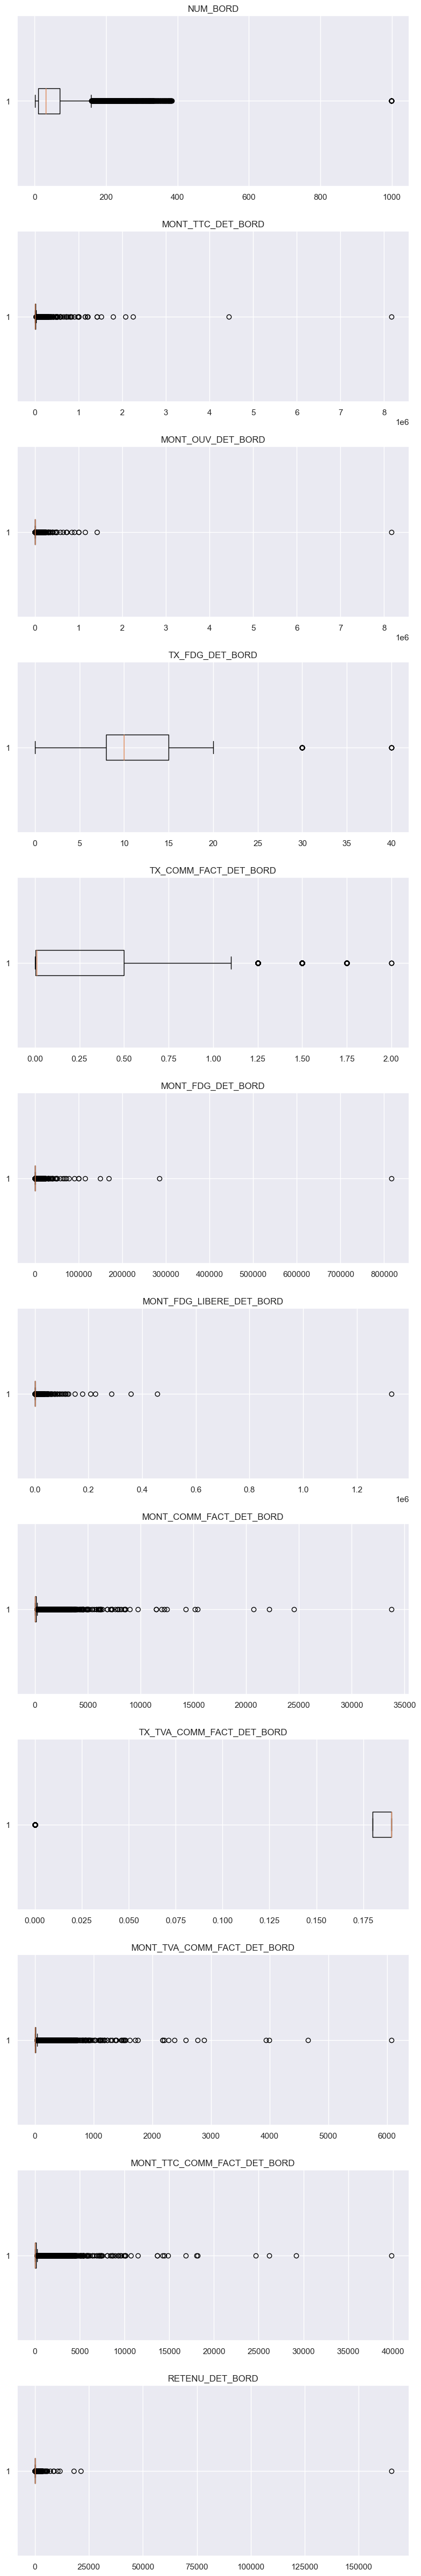

{'columns_with_outliers': {'NUM_BORD': 745,
  'MONT_TTC_DET_BORD': 1964,
  'MONT_OUV_DET_BORD': 1147,
  'TX_FDG_DET_BORD': 24,
  'TX_COMM_FACT_DET_BORD': 2126,
  'MONT_FDG_DET_BORD': 1039,
  'MONT_FDG_LIBERE_DET_BORD': 1881,
  'MONT_COMM_FACT_DET_BORD': 1887,
  'TX_TVA_COMM_FACT_DET_BORD': 670,
  'MONT_TVA_COMM_FACT_DET_BORD': 1856,
  'MONT_TTC_COMM_FACT_DET_BORD': 1882,
  'RETENU_DET_BORD': 3095},
 'total_rows_with_outliers': '7533 / 12792',
 'total_outliers': 7533}

In [27]:
# Visualize outliers in details bord table
visualize_outliers(detb_data)

# Identify outliers
identify_columns_with_outliers(detb_data)

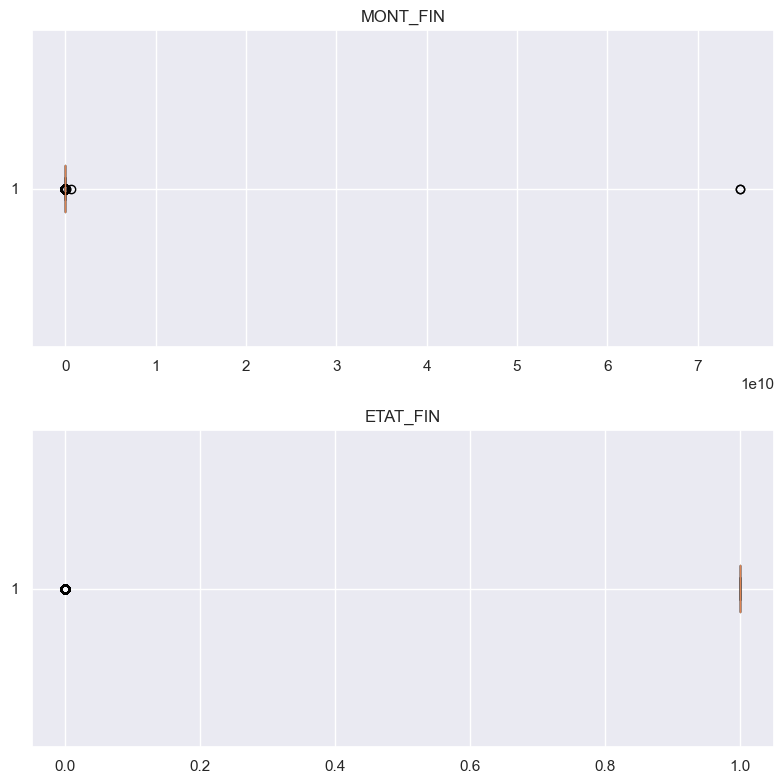

{'columns_with_outliers': {'MONT_FIN': 273, 'ETAT_FIN': 348},
 'total_rows_with_outliers': '588 / 3287',
 'total_outliers': 588}

In [28]:
# Visualize outliers in financing table
visualize_outliers(fin_data)

# Identify outliers
identify_columns_with_outliers(fin_data)

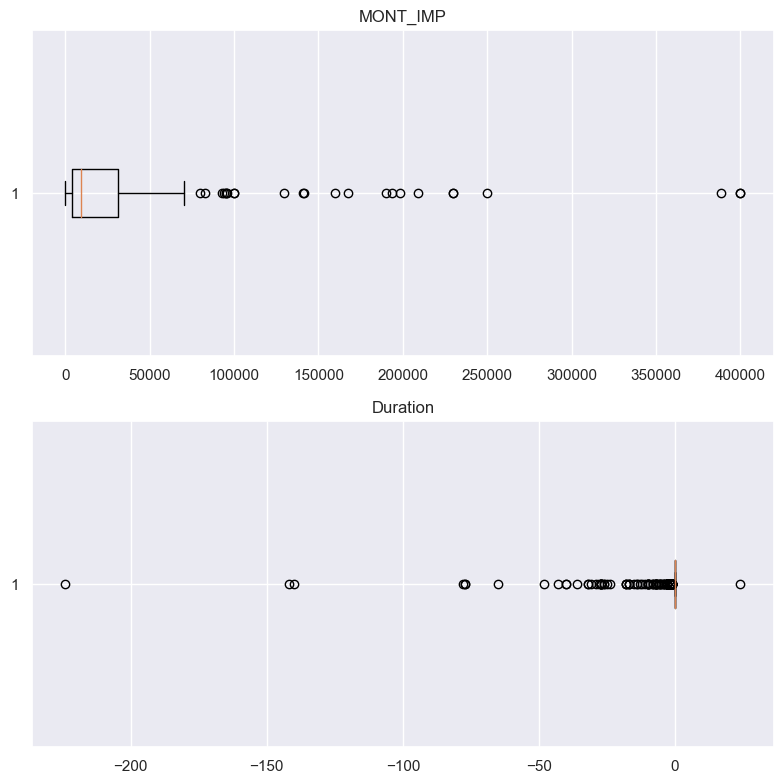

{'columns_with_outliers': {'MONT_IMP': 24, 'Duration': 129},
 'total_rows_with_outliers': '151 / 613',
 'total_outliers': 151}

In [29]:
# Visualize outliers in impaye table
visualize_outliers(imp_data)

# Identify outliers
identify_columns_with_outliers(imp_data)

##### **2. Transform Outliers**

In [30]:
results = identify_columns_with_outliers(ctr_data)

print(f"columns_with_outliers: {results['columns_with_outliers']}")
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

ctr_data = replace_outliers_with_median(ctr_data)

print(f"columns_with_outliers: {results['columns_with_outliers']}")
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

columns_with_outliers: {'CA_CTR': 18, 'CA_EXP_CTR': 1, 'CA_IMP_CTR': 18, 'LIM_FIN_CTR': 19, 'NB_ACH_PREVU_CTR': 16, 'NB_FACT_PREVU_CTR': 10, 'NB_AVOIRS_PREVU_CTR': 8, 'NB_REMISES_PREVU_CTR': 4, 'DELAI_MOYEN_REG_CTR': 1, 'DELAI_MAX_REG_CTR': 25}
total_rows_with_outliers: 57 / 124
columns_with_outliers: {'CA_CTR': 18, 'CA_EXP_CTR': 1, 'CA_IMP_CTR': 18, 'LIM_FIN_CTR': 19, 'NB_ACH_PREVU_CTR': 16, 'NB_FACT_PREVU_CTR': 10, 'NB_AVOIRS_PREVU_CTR': 8, 'NB_REMISES_PREVU_CTR': 4, 'DELAI_MOYEN_REG_CTR': 1, 'DELAI_MAX_REG_CTR': 25}
total_rows_with_outliers: 57 / 124


<Axes: >

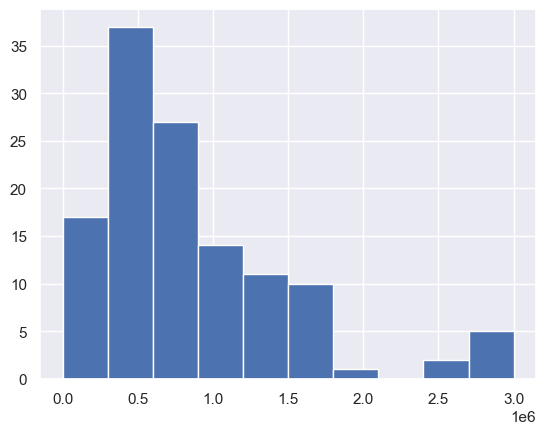

In [31]:
ctr_data['CA_CTR'].hist()

In [32]:
detb_data = remove_outliers_with_percent(detb_data, remove_percent=0.6)

results = identify_columns_with_outliers(detb_data)

print(f"columns_with_outliers: {results['columns_with_outliers']}")
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

# while results['total_outliers'] != 0:
#     # Transform outliers in the contract table
#     detb_data = replace_outliers_with_median(detb_data)

#     # Identify outliers 
#     results = identify_columns_with_outliers(detb_data)
# Transform outliers in the contract table
detb_data = replace_outliers_with_median(detb_data)
detb_data = transform_with_yeojohnson(detb_data)

# Identify outliers 
results = identify_columns_with_outliers(detb_data)

print(f"columns_with_outliers: {results['columns_with_outliers']}")
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

columns_with_outliers: {'NUM_BORD': 86, 'MONT_TTC_DET_BORD': 429, 'MONT_OUV_DET_BORD': 52, 'TX_FDG_DET_BORD': 2891, 'TX_COMM_FACT_DET_BORD': 617, 'MONT_FDG_DET_BORD': 45, 'MONT_FDG_LIBERE_DET_BORD': 386, 'MONT_COMM_FACT_DET_BORD': 289, 'TX_TVA_COMM_FACT_DET_BORD': 128, 'MONT_TVA_COMM_FACT_DET_BORD': 318, 'MONT_TTC_COMM_FACT_DET_BORD': 290, 'RETENU_DET_BORD': 1193}
total_rows_with_outliers: 4016 / 6229
columns_with_outliers: {'MONT_TTC_DET_BORD': 3, 'TX_COMM_FACT_DET_BORD': 174}
total_rows_with_outliers: 177 / 6229


##### **3. Remove Outliers**

In [33]:
results = identify_columns_with_outliers(enc_data)

print(f"columns_with_outliers: {results['columns_with_outliers']}")
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

while results['total_outliers'] != 0:
    # Remove outliers in the encaissemt table 
    enc_data = remove_outliers(enc_data)

    # Identify outliers 
    results = identify_columns_with_outliers(enc_data)
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

columns_with_outliers: {'MONT_ENC': 541}
total_rows_with_outliers: 541 / 13772
total_rows_with_outliers: 0 / 10369


In [34]:
results = identify_columns_with_outliers(fin_data)

print(f"columns_with_outliers: {results['columns_with_outliers']}")
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

while results['total_outliers'] != 0:
    # Remove outliers in the fin table 
    fin_data = remove_outliers(fin_data)

    # Identify outliers 
    results = identify_columns_with_outliers(fin_data)
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

columns_with_outliers: {'MONT_FIN': 273, 'ETAT_FIN': 348}
total_rows_with_outliers: 588 / 3287


total_rows_with_outliers: 0 / 630


In [35]:
results = identify_columns_with_outliers(imp_data)

print(f"columns_with_outliers: {results['columns_with_outliers']}")
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

while results['total_outliers'] != 0:
    # Remove outliers in the impaye table 
    imp_data = remove_outliers(imp_data)

    # Identify outliers 
    results = identify_columns_with_outliers(imp_data)
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

columns_with_outliers: {'MONT_IMP': 24, 'Duration': 129}
total_rows_with_outliers: 151 / 613
total_rows_with_outliers: 0 / 429


In [36]:
results = identify_columns_with_outliers(detb_data)

print(f"columns_with_outliers: {results['columns_with_outliers']}")
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

while results['total_outliers'] != 0:
    # Remove outliers in the det bord table 
    detb_data = remove_outliers(detb_data)

    # Identify outliers 
    results = identify_columns_with_outliers(detb_data)
print(f"total_rows_with_outliers: {results['total_rows_with_outliers']}")

columns_with_outliers: {'MONT_TTC_DET_BORD': 3, 'TX_COMM_FACT_DET_BORD': 174}
total_rows_with_outliers: 177 / 6229


total_rows_with_outliers: 0 / 3641


##### **4. Merge Tables**

In [37]:
# # Combine tables
# try:
#         dataset = ctr_data.merge(enc_data, left_on='REF_CTR', right_on='REF_CTR_ENC', how='inner').drop_duplicates() \
#                 .merge(detb_data, left_on='REF_CTR', right_on='REF_CTR_DET_BORD', how='inner').drop_duplicates() \
#                 .merge(fin_data, left_on='REF_CTR', right_on='REF_CTR_FIN', how='inner').drop_duplicates() \
#                 .merge(imp_data, left_on='ID_ENC', right_on='ID_ENC_IMP', how='inner').drop_duplicates().drop_duplicates()
# except MemoryError:
#         print('Not able to merge tables, due to memory error ')
# except:
#         print('Something else hang out the merge.')
# else:
#         # Display few rows
#         dataset.head()

In [38]:
# Export the files to import them into Oracle SQL Developer
ctr_data.to_csv('ctrc.csv', index=False)
enc_data.to_csv('encc.csv', index=False)
detb_data.to_csv('detbc.csv', index=False)
fin_data.to_csv('finc.csv', index=False)
imp_data.to_csv('impc.csv', index=False)

While the MemoryValue exception still occurs even after some manipulations, we decided to redirect to an SGBDR (Oracle SQL Developer) where we managed to join all the tables together and export the output in a single file call **factoring.csv**. Here's the query:
SELECT * 

FROM contrat c 

INNER join detbord d

 on c.REF_CTR = d.ref_ctr_det_bord
 
INNER join encaissement e

 on c.REF_CTR = e.ref_ctr_enc

INNER join financement f

 on c.REF_CTR = f.REF_CTR_FIN

INNER join impaye i

 on e.ID_enc = i.id_enc_imp

In [39]:
# Read factoring.csv
factoring = pd.read_csv('factoring.csv', parse_dates=['DAT_SIGN_CTR', 'DAT_DEB_CTR', 'DAT_RESIL_CTR', 'DAT_PROCH_VERS_CTR', 'DAT_RECEP_ENC', 'DAT_VAL_ENC', 'DAT_DET_BORD', 'ECH_DET_BORD', 'DAT_FIN', 'DAT_INSTR_FIN', 'DATE_IMP', 'DATE_SAISI_IMP'])
factoring.head()

,REF_CTR,STATUT_CTR,REF_CTR_PAPIER_CTR,TYP_CTR,DAT_SIGN_CTR,DAT_DEB_CTR,DAT_RESIL_CTR,DAT_PROCH_VERS_CTR,CA_CTR,CA_EXP_CTR,...,REF_INSTR_FIN,DAT_INSTR_FIN,ETAT_FIN,REF_INSTR_FIN_FILLED,ID_IMP,ID_ENC_IMP,DATE_IMP,DATE_SAISI_IMP,MONT_IMP,DURATION
0,48,V,006/2015,Avec recours,2015-10-20,2015-10-20,2015-10-27,2015-10-27,500000.0,0.0,...,0,2017-12-27,1,2019267,482,12193,2020-01-09,2020-01-09,5613.819,0
1,48,V,006/2015,Avec recours,2015-10-20,2015-10-20,2015-10-27,2015-10-27,500000.0,0.0,...,0,2017-12-18,1,2019267,482,12193,2020-01-09,2020-01-09,5613.819,0
2,48,V,006/2015,Avec recours,2015-10-20,2015-10-20,2015-10-27,2015-10-27,500000.0,0.0,...,0,2017-12-12,1,2019267,482,12193,2020-01-09,2020-01-09,5613.819,0
3,48,V,006/2015,Avec recours,2015-10-20,2015-10-20,2015-10-27,2015-10-27,500000.0,0.0,...,0,2017-12-08,1,2019267,482,12193,2020-01-09,2020-01-09,5613.819,0
4,48,V,006/2015,Avec recours,2015-10-20,2015-10-20,2015-10-27,2015-10-27,500000.0,0.0,...,0,2017-11-15,1,2019267,482,12193,2020-01-09,2020-01-09,5613.819,0


In [40]:
factoring.shape

(690561, 68)

##### **5. Remove IDs and References**

In [41]:
# Remove prefixes that represent IDs and References
factoring = remove_columns_starting_with_prefix(factoring, prefix_list=['REF', 'ID', 'NUM'])

factoring.shape

(690561, 52)

In [42]:
factoring.columns

Index(['STATUT_CTR', 'TYP_CTR', 'DAT_SIGN_CTR', 'DAT_DEB_CTR', 'DAT_RESIL_CTR',
       'DAT_PROCH_VERS_CTR', 'CA_CTR', 'CA_EXP_CTR', 'CA_IMP_CTR',
       'LIM_FIN_CTR', 'DEVISE_CTR', 'NB_ACH_PREVU_CTR', 'NB_FACT_PREVU_CTR',
       'NB_AVOIRS_PREVU_CTR', 'NB_REMISES_PREVU_CTR', 'DELAI_MOYEN_REG_CTR',
       'DELAI_MAX_REG_CTR', 'FACT_REG_CTR', 'DERN_MONT_DISP_2', 'TYP_DET_BORD',
       'DAT_DET_BORD', 'MONT_TTC_DET_BORD', 'DEVISE_DET_BORD', 'ECH_DET_BORD',
       'MONT_OUV_DET_BORD', 'MODE_REG_DET_BORD', 'TX_FDG_DET_BORD',
       'TX_COMM_FACT_DET_BORD', 'ANNUL_DET_BORD', 'VALIDE_DET_BORD',
       'MONT_FDG_DET_BORD', 'MONT_FDG_LIBERE_DET_BORD',
       'MONT_COMM_FACT_DET_BORD', 'TX_TVA_COMM_FACT_DET_BORD',
       'MONT_TVA_COMM_FACT_DET_BORD', 'MONT_TTC_COMM_FACT_DET_BORD',
       'RETENU_DET_BORD', 'MONT_ENC', 'DEVISE_ENC', 'DAT_RECEP_ENC',
       'DAT_VAL_ENC', 'TYP_ENC', 'VALIDE_ENC', 'MONT_FIN', 'DAT_FIN',
       'INSTR_FIN', 'DAT_INSTR_FIN', 'ETAT_FIN', 'DATE_IMP', 'DATE_SAISI_IMP

##### **6. Create a new column that represents credibility**

In [43]:
# Define the credibility criteria based on multiple columns
def determine_credibility(df):
    
    credibility = []

    # Define your criteria based on the columns
    for ind, row in df.iterrows():
        if (row['DELAI_MAX_REG_CTR'] <= 120 and
            row['CA_CTR'] >= 600000.0 and
            row['NB_FACT_PREVU_CTR'] >= 50 and
            row['MONT_TTC_DET_BORD'] >= 10.0 and
            row['MONT_IMP'] >= 2000.0):
            credibility.append(1)  # Credible
        else:
            credibility.append(0)  # Not credible

    return pd.Series(credibility)

In [44]:
print(factoring['DELAI_MAX_REG_CTR'].value_counts())
print(factoring['CA_CTR'].value_counts())
print(factoring['NB_AVOIRS_PREVU_CTR'].value_counts())
print(factoring['NB_FACT_PREVU_CTR'].value_counts())
print(factoring['MONT_TTC_DET_BORD'].value_counts())
print(factoring['MONT_ENC'].value_counts())
print(factoring['MONT_IMP'].value_counts())

120.0    466720
90.0     223791
150.0        50
Name: DELAI_MAX_REG_CTR, dtype: int64
800000.0     222448
400000.0     221223
1500000.0    180930
500000.0      28392
1200000.0     17340
600000.0      11544
300000.0       8660
100000.0         24
Name: CA_CTR, dtype: int64
0.0     246827
0.5     240898
10.0    191292
25.0     11544
Name: NB_AVOIRS_PREVU_CTR, dtype: int64
50     406025
100    220126
150     33462
30      28896
45       2028
10         24
Name: NB_FACT_PREVU_CTR, dtype: int64
15.726434    87337
11.814616     2871
20.404333     2421
11.100565     2349
15.291768     2180
             ...  
20.150864        5
20.660211        5
21.421710        5
20.228622        4
20.417716        4
Name: MONT_TTC_DET_BORD, Length: 2836, dtype: int64
13699.972    28980
2957.780     28980
3759.906     28980
1161.131     28980
1393.243     28980
             ...  
24939.569       26
22000.000       26
39589.652       26
29435.947       12
2950.000        12
Name: MONT_ENC, Length: 170, dtype:

In [45]:
# Apply the credibility criteria to create the target variable
factoring['Credibility'] = determine_credibility(factoring)

# Display the resulting DataFrame with the target variable
factoring['Credibility'].value_counts()

0    386448
1    304113
Name: Credibility, dtype: int64

##### **7. Check Correlation**

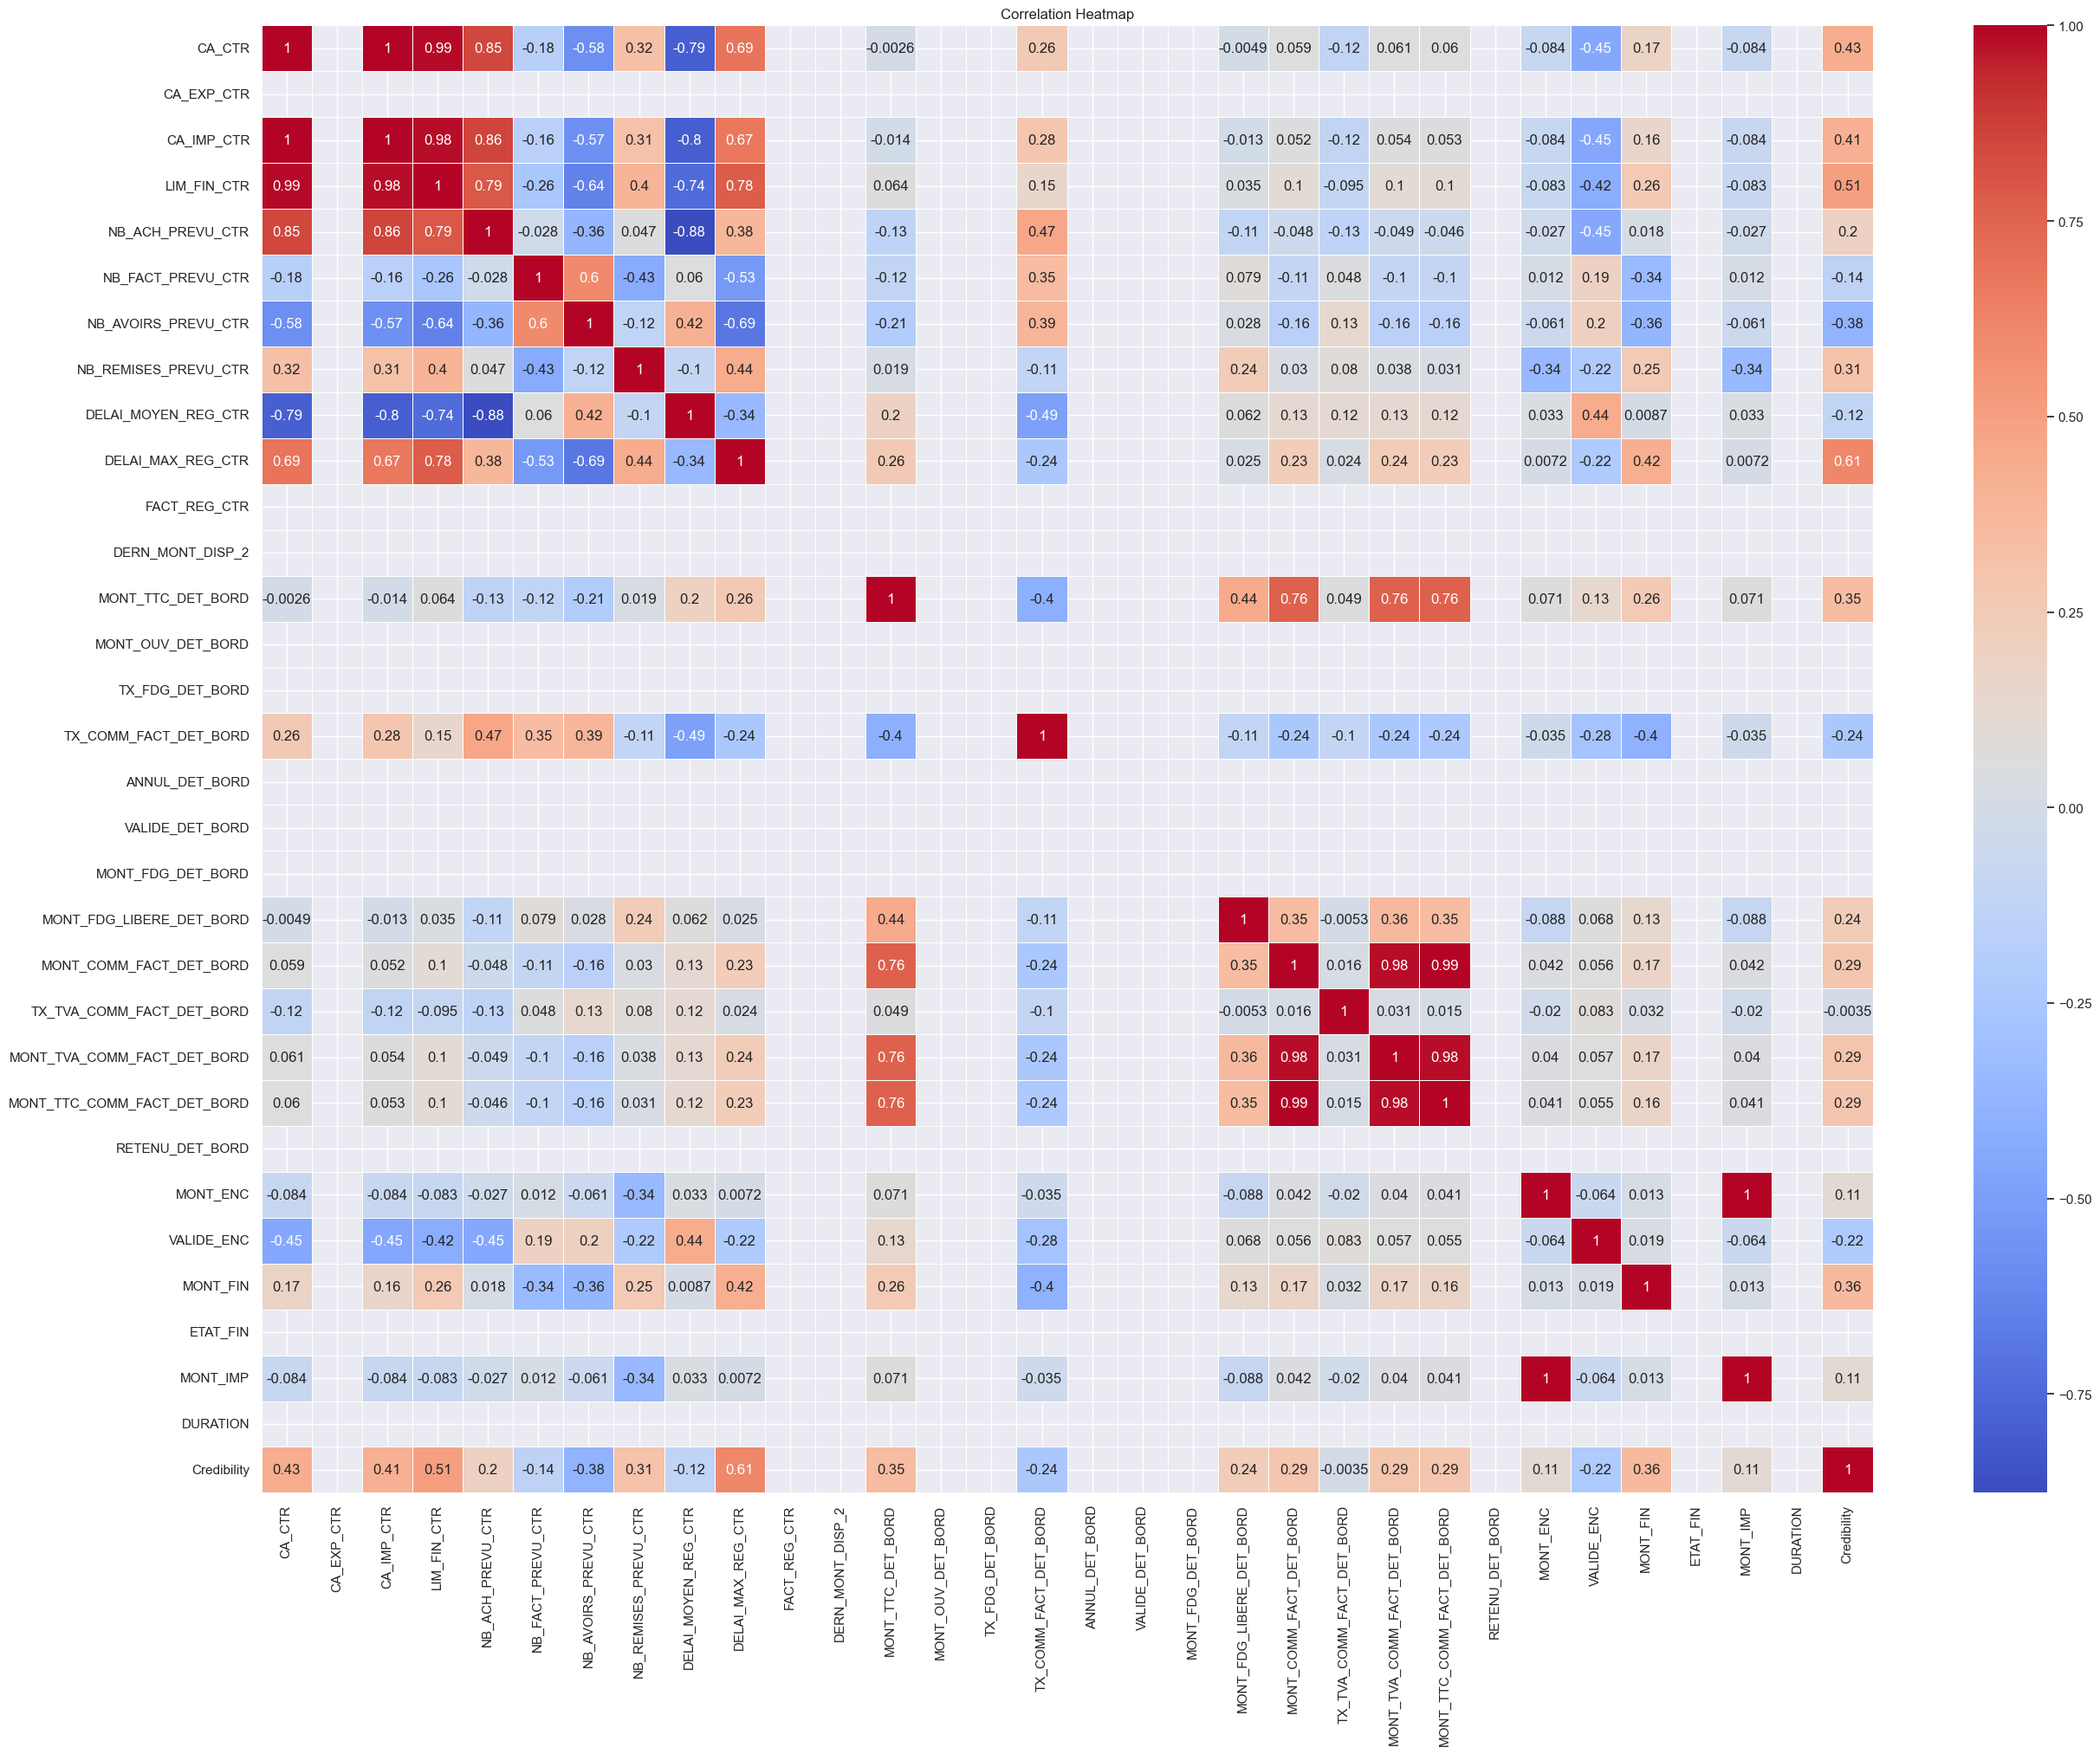

In [46]:
# Calculate the correlation matrix
correlation_matrix = factoring.corr()

# Create a heatmap
plt.figure(figsize=(30, 22))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

It looks like some columns have not been considered during the correlation process, as they may present either objects or datetimes. For this reason, we're going to make some preprocessing including Standardization (Scaling), Label Encoding and datetime transformation. Lastly, we'll re-check the correlations with HeatMap.

In [47]:
# Preprocess data
factoring = preprocess_data(factoring)

# Verify output
print(factoring.dtypes)
factoring.head()

STATUT_CTR                       int32
TYP_CTR                          int32
DAT_SIGN_CTR                   float64
DAT_DEB_CTR                    float64
DAT_RESIL_CTR                  float64
DAT_PROCH_VERS_CTR             float64
CA_CTR                         float64
CA_EXP_CTR                     float64
CA_IMP_CTR                     float64
LIM_FIN_CTR                    float64
DEVISE_CTR                       int32
NB_ACH_PREVU_CTR               float64
NB_FACT_PREVU_CTR              float64
NB_AVOIRS_PREVU_CTR            float64
NB_REMISES_PREVU_CTR           float64
DELAI_MOYEN_REG_CTR            float64
DELAI_MAX_REG_CTR              float64
FACT_REG_CTR                      bool
DERN_MONT_DISP_2               float64
TYP_DET_BORD                     int32
DAT_DET_BORD                   float64
MONT_TTC_DET_BORD              float64
DEVISE_DET_BORD                  int32
ECH_DET_BORD                     int32
MONT_OUV_DET_BORD              float64
MODE_REG_DET_BORD        

,STATUT_CTR,TYP_CTR,DAT_SIGN_CTR,DAT_DEB_CTR,DAT_RESIL_CTR,DAT_PROCH_VERS_CTR,CA_CTR,CA_EXP_CTR,CA_IMP_CTR,LIM_FIN_CTR,...,MONT_FIN,DAT_FIN,INSTR_FIN,DAT_INSTR_FIN,ETAT_FIN,DATE_IMP,DATE_SAISI_IMP,MONT_IMP,DURATION,Credibility
0,1,0,1.445299e+09,1.445299e+09,1.445904e+09,1.445904e+09,-0.789118,0.0,-0.768916,-0.829073,...,-1.070974,1.514333e+09,0,1.514333e+09,0.0,1.578528e+09,1.578528e+09,-0.169884,0.0,0
1,1,0,1.445299e+09,1.445299e+09,1.445904e+09,1.445904e+09,-0.789118,0.0,-0.768916,-0.829073,...,2.343361,1.513555e+09,0,1.513555e+09,0.0,1.578528e+09,1.578528e+09,-0.169884,0.0,0
2,1,0,1.445299e+09,1.445299e+09,1.445904e+09,1.445904e+09,-0.789118,0.0,-0.768916,-0.829073,...,-1.161884,1.513037e+09,0,1.513037e+09,0.0,1.578528e+09,1.578528e+09,-0.169884,0.0,0
3,1,0,1.445299e+09,1.445299e+09,1.445904e+09,1.445904e+09,-0.789118,0.0,-0.768916,-0.829073,...,-1.113855,1.512691e+09,0,1.512691e+09,0.0,1.578528e+09,1.578528e+09,-0.169884,0.0,0
4,1,0,1.445299e+09,1.445299e+09,1.445904e+09,1.445904e+09,-0.789118,0.0,-0.768916,-0.829073,...,-0.220995,1.510704e+09,0,1.510704e+09,0.0,1.578528e+09,1.578528e+09,-0.169884,0.0,0


Outstanding preprocessing, so far !

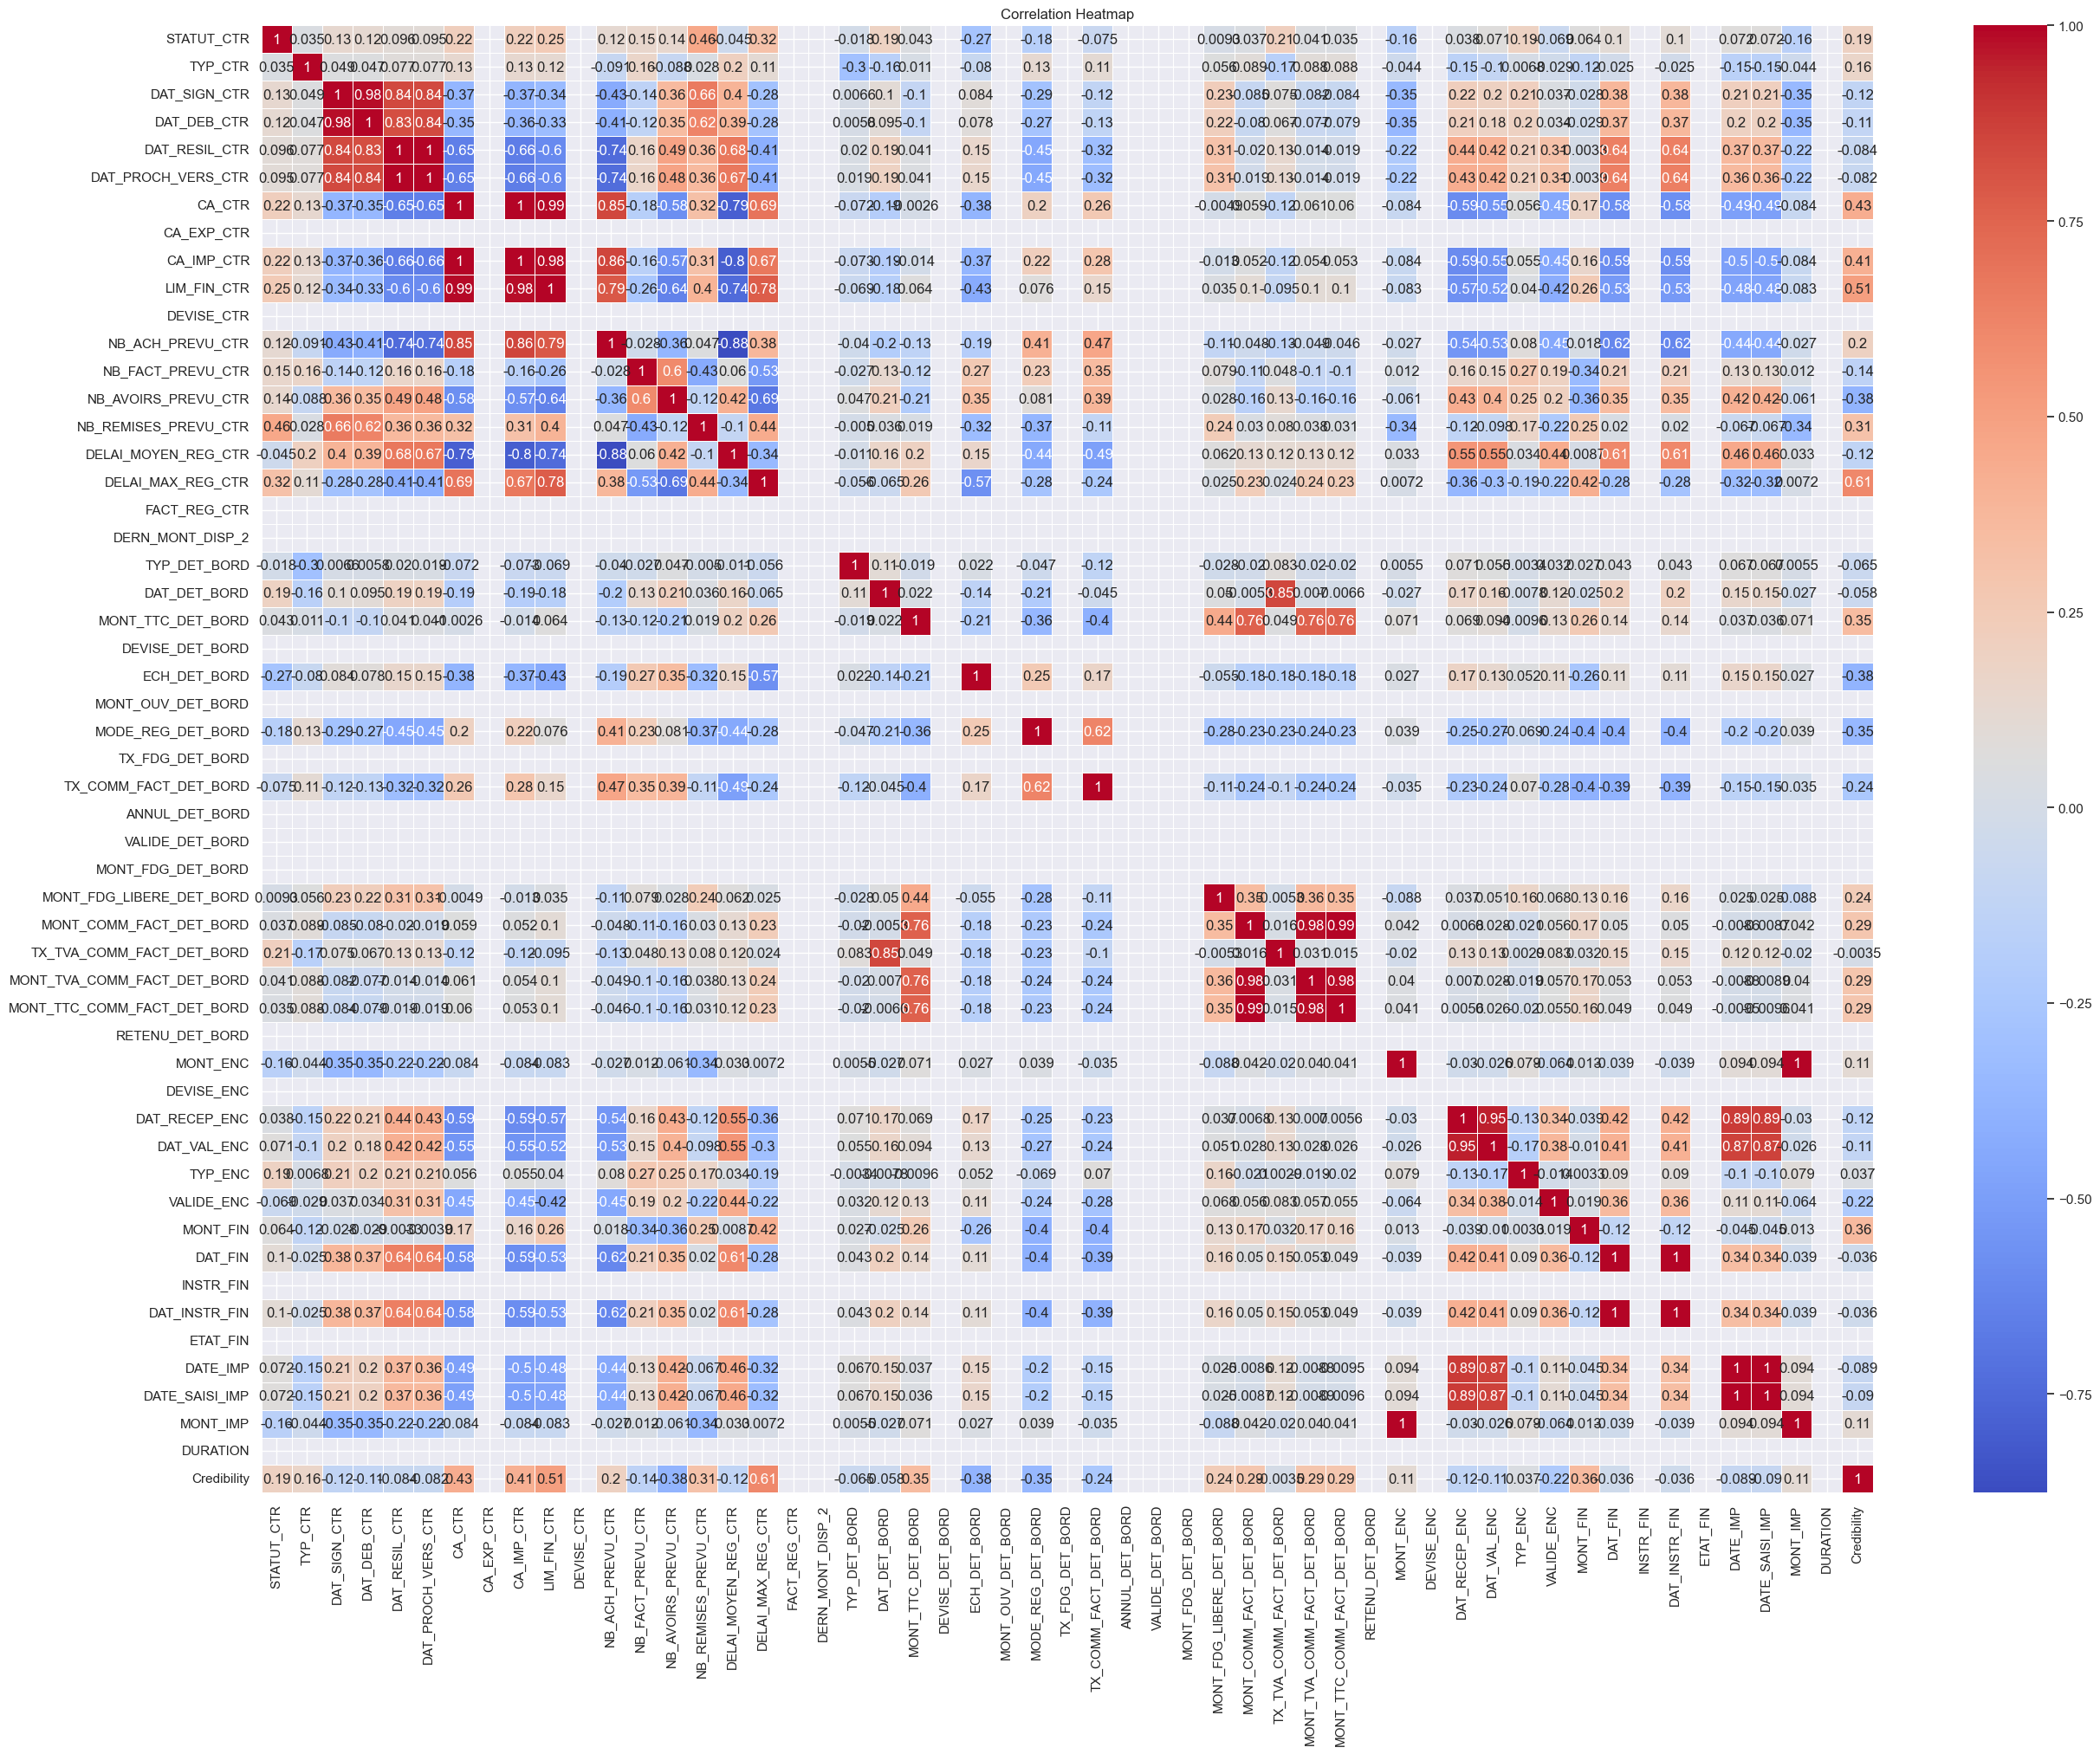

In [48]:
# Calculate the correlation matrix
correlation_matrix = factoring.corr()

# Create a heatmap
plt.figure(figsize=(30, 22))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

Time to fetch correlated columns that have correlation either more than 0.3 or less than -0.3

In [50]:
# Get correlated columns
factoring_corr = get_correlated_columns(factoring, threshold=0.3)

# Display columns and df shape
print(factoring_corr.shape)
factoring_corr.sample(5)

(690561, 11)


,CA_CTR,CA_IMP_CTR,LIM_FIN_CTR,NB_AVOIRS_PREVU_CTR,NB_REMISES_PREVU_CTR,DELAI_MAX_REG_CTR,MONT_TTC_DET_BORD,ECH_DET_BORD,MODE_REG_DET_BORD,MONT_FIN,Credibility
30181,-0.099598,-0.138244,0.125585,-0.551590,0.745715,0.692077,-0.283986,4,0,0.097581,1
661062,-1.248797,-1.227585,-1.147292,-0.551590,0.745715,0.692077,0.260519,4,1,-1.141122,0
261172,-0.099598,-0.138244,0.125585,-0.551590,0.745715,0.692077,1.237300,4,0,0.097581,1
433747,-0.099598,-0.138244,0.125585,-0.551590,0.745715,0.692077,1.203812,4,0,0.097581,0
124969,-1.018958,-0.998250,-1.147292,1.279054,-0.396941,-1.443971,0.234022,115,1,-0.681735,0


### **Machine Learning (Prediction)**

After finishing all the preprocessing steps, it's time to play around the prediction stone where will be tackling with different machine learning algorithms (models) including RandomForest, Logistic Regression,...

##### **1. Split data**

In [51]:
# Drop the 'Credibility' column to prepare data for splitting
X = factoring_corr.drop(columns=['Credibility'])

# Get the target variable
y = factoring_corr['Credibility']

# Split data into training, validation and test sets, ensuring the class distribution is maintained
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

##### **2. Data modeling**

##### **2.1. Logistic Regression**

In [52]:
# Create a Logistic Regression model
logistic_regression = LogisticRegression()

# Define hyperparameters and their possible values for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['sag'],  # sag=(Stochastic Average Gradient), suitable for large datasets
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Train a Logistic Regression model with the best hyperparameters
best_logistic_regression = LogisticRegression(**best_params)
best_logistic_regression.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_logistic_regression.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("Best Hyperparameters:", best_params)
print("Test Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
Test Accuracy: 0.8331830934926238
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84    154506
           1       0.76      0.90      0.83    121719

    accuracy                           0.83    276225
   macro avg       0.84      0.84      0.83    276225
weighted avg       0.84      0.83      0.83    276225



- The Logistic Regression model achieved an accuracy of approximately 83.32% on the test dataset.
- For class 0 (not credible loans), the model correctly predicts about 91% of them with a precision of 0.91 and identifies approximately 78% of the actual not credible loans with a recall of 0.78.
- For class 1 (credible loans), the model correctly predicts about 76% of them with a precision of 0.76 and identifies approximately 90% of the actual credible loans with a recall of 0.90.
- The F1-scores for both classes are approximately 0.84 and 0.83, indicating a reasonable balance between precision and recall.
- The macro and weighted average metrics are both around 0.83, reflecting good overall model performance.

In summary, the model demonstrates good accuracy and a balanced performance in correctly identifying both credible and not credible loans.

[[120855  33651]
 [ 12428 109291]]


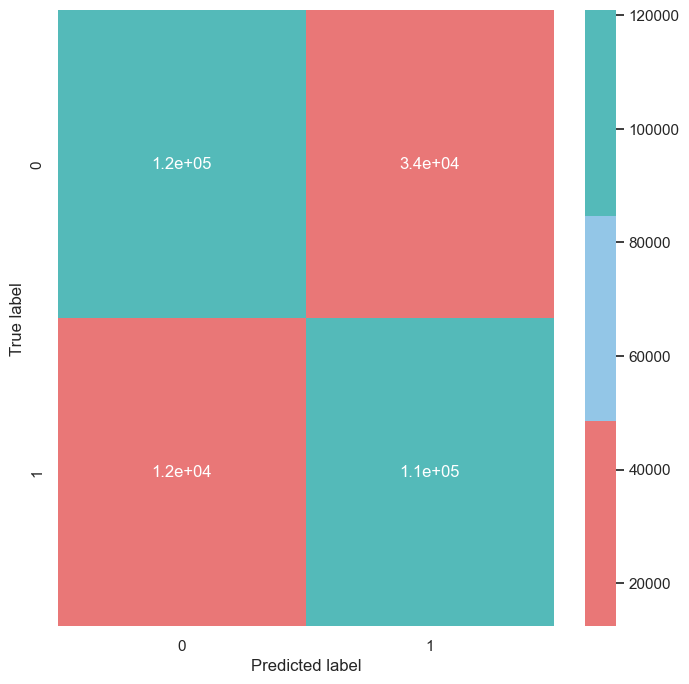

In [53]:
# Displaying the matrix 
print(confusion_matrix(y_test, y_pred))
custom_confusion_matrix(factoring_corr, y_test, y_pred)

##### **2.2. Random Forest**

In [54]:
# Create a Random Forest Classifier model
random_forest = RandomForestClassifier(n_estimators=200, random_state=42)
random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("Test Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Test Accuracy: 0.8323576794280025
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84    154506
           1       0.76      0.91      0.83    121719

    accuracy                           0.83    276225
   macro avg       0.84      0.84      0.83    276225
weighted avg       0.85      0.83      0.83    276225



[[119260  35246]
 [ 11061 110658]]


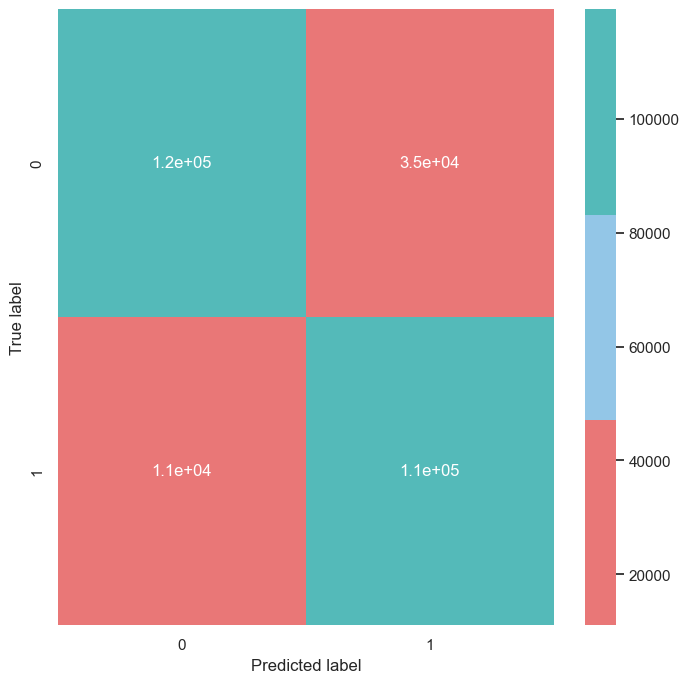

In [55]:
# Displaying the matrix 
print(confusion_matrix(y_test, y_pred))
custom_confusion_matrix(factoring_corr, y_test, y_pred)

- **Test Accuracy:** The model achieved an accuracy of approximately 83.24% on the test dataset. This means that out of all the samples in the test set, the model correctly predicted the class (credible or not credible) for about 83.24% of them.

- **Precision:** Precision is a measure of how many of the positive predictions made by the model were correct. For class 0 (not credible), the precision is approximately 0.92, which means that when the model predicts a loan as "not credible," it is correct about 92% of the time. For class 1 (credible), the precision is approximately 0.76, indicating that when the model predicts a loan as "credible," it is correct about 76% of the time.

- **Recall:** Recall is a measure of how many of the actual positive cases the model predicted correctly. For class 0 (not credible), the recall is approximately 0.77, meaning that the model correctly identifies about 77% of the actual "not credible" loans. For class 1 (credible), the recall is approximately 0.91, indicating that the model correctly identifies about 91% of the actual "credible" loans.

- **F1-Score:** The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics. For class 0, the F1-score is approximately 0.84, and for class 1, it's approximately 0.83. These values suggest a reasonable balance between precision and recall for both classes.

- **Support:** Support indicates the number of samples in each class in the test set. There are 154,506 samples in class 0 (not credible) and 121,719 samples in class 1 (credible).

- **Macro Avg and Weighted Avg:** These metrics provide average values for precision, recall, and F1-score, considering both classes. The macro average gives equal weight to each class, while the weighted average considers class imbalance. In this case, both macro and weighted averages are around 0.83, indicating good overall model performance.

##### **2.3. Gaussian Naive Bayes**

In [56]:
# Create a Gaussian Naive Bayes Classifier model
gaussian_nb = GaussianNB()

# Train the model on the training data
gaussian_nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gaussian_nb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("Test Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


Test Accuracy: 0.7987148158204362
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.68      0.79    154506
           1       0.70      0.95      0.81    121719

    accuracy                           0.80    276225
   macro avg       0.82      0.81      0.80    276225
weighted avg       0.84      0.80      0.80    276225



[[105026  49480]
 [  6120 115599]]


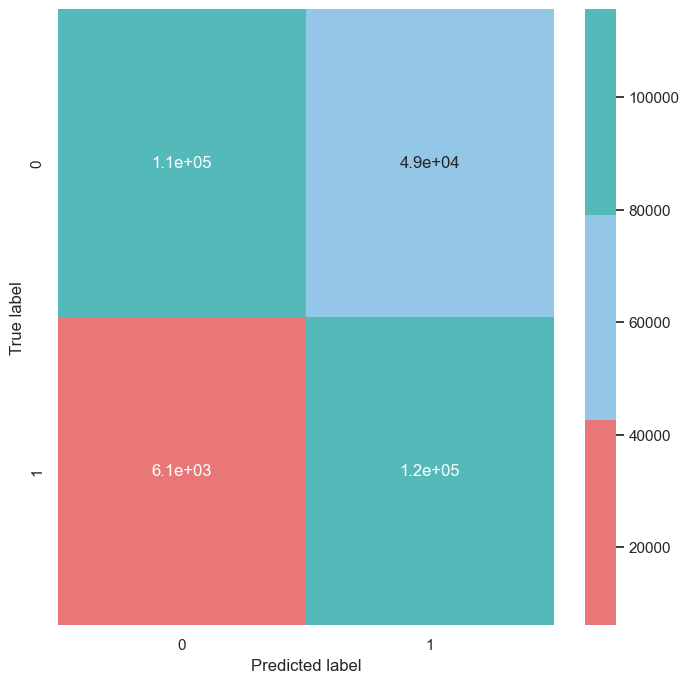

In [57]:
# Displaying the matrix 
print(confusion_matrix(y_test, y_pred))
custom_confusion_matrix(factoring_corr, y_test, y_pred)

- **Test Accuracy:** The Gaussian Naive Bayes model achieved an accuracy of approximately 79.87% on the test dataset. This means that out of all the samples in the test set, the model correctly predicted the class (credible or not credible) for about 79.87% of them.

- **Precision:** Precision is a measure of how many of the positive predictions made by the model were correct. For class 0 (not credible), the precision is approximately 0.94, which means that when the model predicts a loan as "not credible," it is correct about 94% of the time. For class 1 (credible), the precision is approximately 0.70, indicating that when the model predicts a loan as "credible," it is correct about 70% of the time.

- **Recall:** Recall is a measure of how many of the actual positive cases the model predicted correctly. For class 0 (not credible), the recall is approximately 0.68, meaning that the model correctly identifies about 68% of the actual "not credible" loans. For class 1 (credible), the recall is approximately 0.95, indicating that the model correctly identifies about 95% of the actual "credible" loans.

- **F1-Score:** The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics. For class 0, the F1-score is approximately 0.79, and for class 1, it's approximately 0.81. These values suggest a reasonable balance between precision and recall for both classes.

- **Support:** Support indicates the number of samples in each class in the test set. There are 154,506 samples in class 0 (not credible) and 121,719 samples in class 1 (credible).

- **Macro Avg and Weighted Avg:** These metrics provide average values for precision, recall, and F1-score, considering both classes. The macro average gives equal weight to each class, while the weighted average considers class imbalance. In this case, both macro and weighted averages are around 0.80, indicating good overall model performance.

##### **2.4. XGBoost (Extreme Gradient Boosting)**

In [58]:
# Create an XGBoost Classifier model with learning rate and n_estimators
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification objective
    eval_metric='logloss',        # Logarithmic loss (logloss) as the evaluation metric
    learning_rate=0.1,            # Learning rate
    n_estimators=100              # Number of boosting rounds
)

# Train the model on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("Test Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Test Accuracy: 0.8652692551362114
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.86    154506
           1       0.77      1.00      0.87    121719

    accuracy                           0.87    276225
   macro avg       0.88      0.88      0.87    276225
weighted avg       0.90      0.87      0.86    276225



[[117346  37160]
 [    56 121663]]


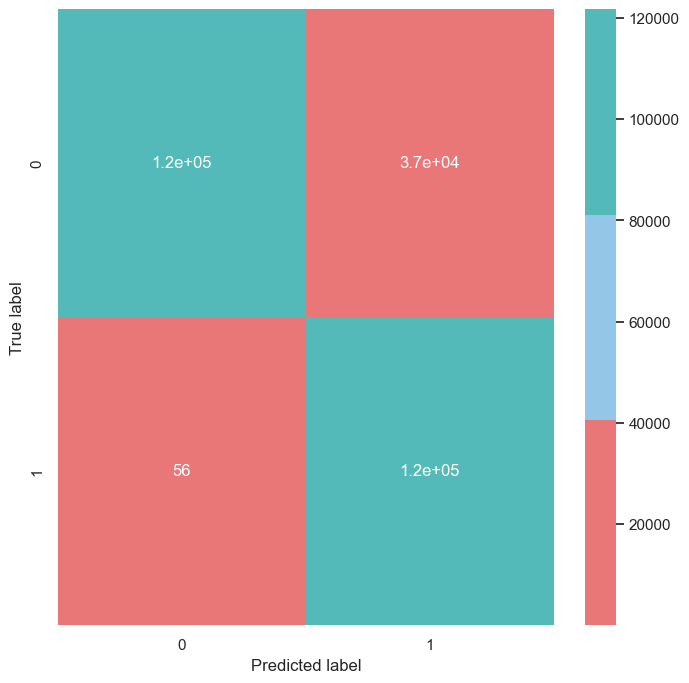

In [59]:
# Displaying the matrix 
print(confusion_matrix(y_test, y_pred))
custom_confusion_matrix(factoring_corr, y_test, y_pred)

- **Test Accuracy:** The XGBoost model achieved an accuracy of approximately 86.53% on the test dataset. This means that out of all the samples in the test set, the model correctly predicted the class (credible or not credible) for about 86.53% of them.

- **Precision:** Precision is a measure of how many of the positive predictions made by the model were correct. For class 0 (not credible), the precision is approximately 1.00, which means that when the model predicts a loan as "not credible," it is correct about 100% of the time. For class 1 (credible), the precision is approximately 0.77, indicating that when the model predicts a loan as "credible," it is correct about 77% of the time.

- **Recall:** Recall is a measure of how many of the actual positive cases the model predicted correctly. For class 0 (not credible), the recall is approximately 0.76, meaning that the model correctly identifies about 76% of the actual "not credible" loans. For class 1 (credible), the recall is approximately 1.00, indicating that the model correctly identifies about 100% of the actual "credible" loans.

- **F1-Score:** The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics. For class 0, the F1-score is approximately 0.86, and for class 1, it's approximately 0.87. These values suggest a good balance between precision and recall for both classes.

- **Support:** Support indicates the number of samples in each class in the test set. There are 154,506 samples in class 0 (not credible) and 121,719 samples in class 1 (credible).

- **Macro Avg and Weighted Avg:** These metrics provide average values for precision, recall, and F1-score, considering both classes. The macro average gives equal weight to each class, while the weighted average considers class imbalance. In this case, both macro and weighted averages are around 0.87, indicating good overall model performance.

##### **3. Global Interpretation**

We evaluated several machine learning models, including Logistic Regression, XGBoost, Gaussian Naive Bayes, and Random Forest, for a binary classification task to predict the credibility of loan applications.

1. **Logistic Regression:**
   - Achieved an accuracy of approximately 83.32% on the test dataset.

2. **Random Forest:**
   - Achieved an accuracy of approximately 83.24% on the test dataset.

3. **XGBoost (Extreme Gradient Boosting):**
   - Achieved a high accuracy of approximately 86.53% on the test dataset.

4. **Gaussian Naive Bayes:**
   - Achieved an accuracy of approximately 79.87% on the test dataset.

In summary, all models showed strong predictive capabilities, with accuracy ranging from approximately 79.87% to 86.53%. 

XGBoost demonstrated the highest accuracy and balanced precision and recall values, making it a top choice for this binary classification task.